In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [27]:
ny311_df = pd.read_csv('New_York_NY_311.csv')

/Users/joycezh/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,18,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
#aggregate 311 call 
ny311_df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude
0,45282225,01/01/2020 12:01:12 AM,01/01/2020 03:07:10 AM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11210.0,511 EAST 28 STREET,...,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,40.637989,-73.950108
1,45281175,01/01/2020 12:01:37 AM,01/01/2020 01:54:21 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10468.0,2625 GRAND CONCOURSE,...,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,40.865154,-73.895088
2,45278238,01/01/2020 12:01:46 AM,01/01/2020 05:37:46 AM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,NaN,10025.0,865 COLUMBUS AVENUE,...,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,40.796930,-73.964551
3,45280733,01/01/2020 12:01:56 AM,01/01/2020 07:48:16 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11103.0,25-88 46 STREET,...,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,40.765270,-73.907281
4,45281554,01/01/2020 12:03:23 AM,01/01/2020 05:24:53 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11222.0,211 INDIA STREET,...,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,40.732665,-73.951101


In [29]:
ny311_df = ny311_df[['Created Date']]
ny311_df['Created Date']=ny311_df['Created Date'].apply(lambda x:x[0:11])
ny311_df['Created Date']= pd.to_datetime(ny311_df['Created Date'])
ny311_df['311 Call Volume'] = 1
ny311_df = ny311_df.groupby(['Created Date']).count().reset_index()
ny311_ts =ny311_df.rename(columns={"Created Date": "Date"})
ny311_ts = ny311_ts.set_index('Date')

In [30]:
ny311_ts

,311 Call Volume
Date,
2020-01-01,4433
2020-01-02,6379
2020-01-03,5629
2020-01-04,4591
2020-01-05,4680
...,...
2022-03-10,8197
2022-03-11,7957
2022-03-12,6390


In [31]:
#aggregate license
license = pd.read_csv('Liquor_Authority_Current_List_of_Active_Licenses.csv')

/Users/joycezh/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [32]:
license=license[['Effective Date']]
license['Effective Date']=pd.to_datetime(license['Effective Date'])
license = license[(license['Effective Date'] >= '2020-01-01')&(license['Effective Date'] <= '2022-03-14')]
license=license.sort_values(by=['Effective Date'])
license['Increase of active Liquor Bisunesses']=1
license=license.groupby(['Effective Date']).sum().reset_index()
license =license.rename(columns={"Effective Date": "Date"})
license_ts = license.set_index('Date')

In [33]:
license_ts

,Increase of active Liquor Bisunesses
Date,
2020-01-01,330
2020-01-02,9
2020-01-03,21
2020-01-06,14
2020-01-07,10
...,...
2022-03-08,23
2022-03-09,22
2022-03-10,19


# 1. Plot 311 Call Volume

Text(0.5, 1.0, 'Plot of 311 Call Volume')

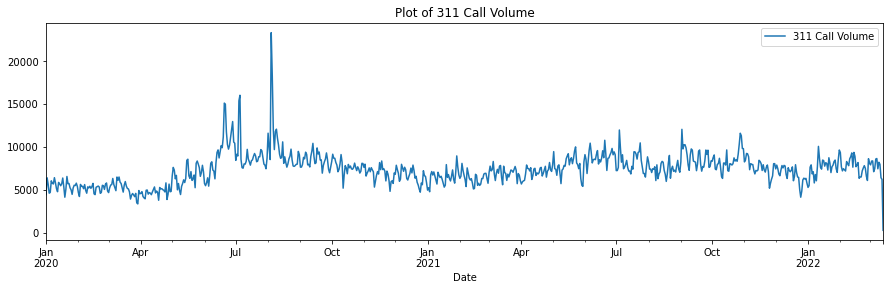

In [34]:
#call volume original plot
ny311_ts.plot(y=['311 Call Volume'], figsize=(15,4)).set_title('Plot of 311 Call Volume')

Text(0.5, 1.0, 'Rolling Window Plot of 311 Call Volume')

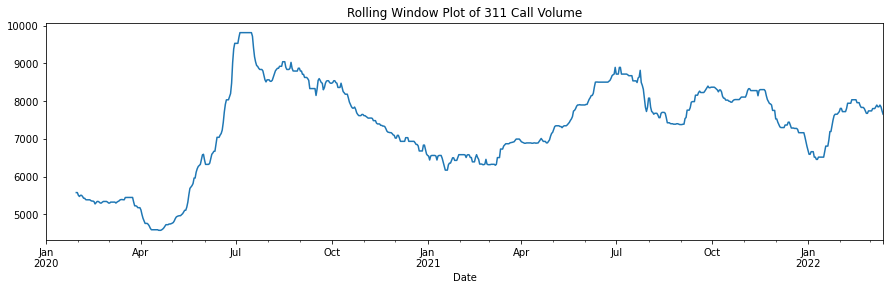

In [35]:
#Total count rolling plot
ny311_ts['311 Call Volume'].rolling(30).median().plot(figsize=(15,4)).set_title('Rolling Window Plot of 311 Call Volume')

A rollong window smoothes the call volume plot. Based on this plot, we observe an slightly upward trend and some seasonality patterns (peaks around July and valleys around January).
This suggests that we should be able to do a time series analysis regrading the 311 call volume
To look in detail, let's do a multiplicative decomposition by month.

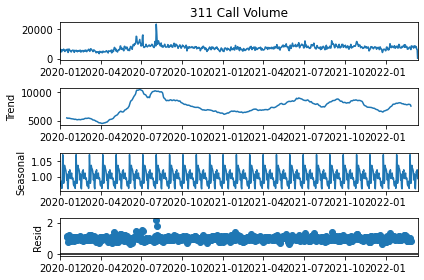

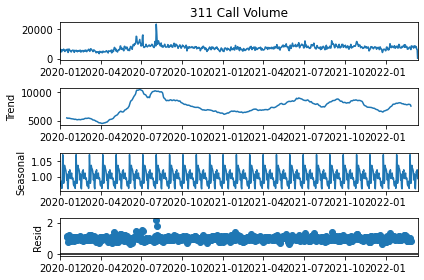

In [36]:
decomp =seasonal_decompose(ny311_ts['311 Call Volume'], model='multiplicative',period = 30)
decomp.plot()

We have meaningful obeservations: upward trend, seasonal pattern within each month, and also resonal residules around 1 for this multiplicative decomposition.
We could explore further with 311 call volume and discover if it is related to another time series, which is also of our interest - number of new liquor license business.

# 2.visualize call volume vs new liquor license business

In [37]:
# visualize call volume vs new liquor license business

Text(0.5, 1.0, 'Plot of Increase of Active Liquor-licensed Business')

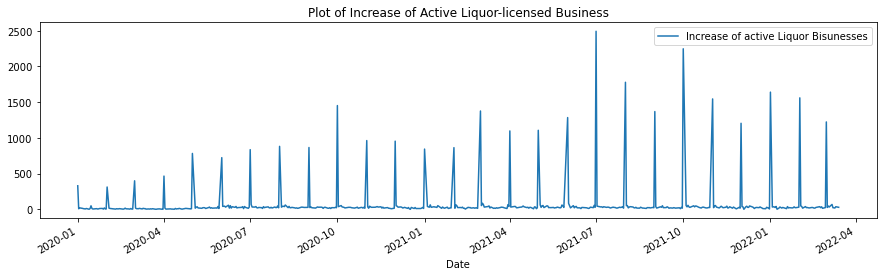

In [38]:
#New business original plot
license_ts.plot(y=['Increase of active Liquor Bisunesses'], figsize=(15,4)).set_title('Plot of Increase of Active Liquor-licensed Business')

This plot shows increment of liquor-licensed business each day(referenced from new businesses' liquor license effective date). From this plot, clearly there's peak at the first day of each month. We can also obersve an upward trend and some seasonal patterns like yearly peaks ususally happen in July to october.
Will this have some internal relationship with our 311 call volume in NY?
Let's take log of both time series to stablize and observe. 

In [39]:
license_ts_log = license_ts.copy()
license_ts_log['Increase of active Liquor Bisunesses']= np.log(license_ts['Increase of active Liquor Bisunesses'])

In [40]:
ny311_ts_log = ny311_ts[['311 Call Volume']].copy()

In [41]:
ny311_ts_log['311 Call Volume']=np.log(ny311_ts['311 Call Volume'])

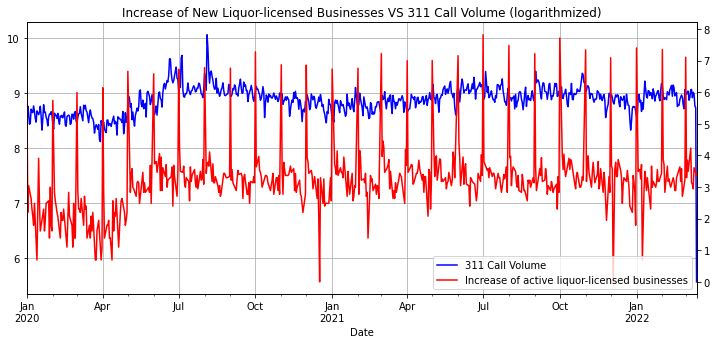

In [43]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = ny311_ts_log['311 Call Volume'].plot(color='blue', grid=True, label='311 Call Volume')
ax2 = license_ts_log['Increase of active Liquor Bisunesses'].plot(color='red', secondary_y=True, grid=True,label='Increase of active liquor-licensed businesses')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=4)
plt.title('Increase of New Liquor-licensed Businesses VS 311 Call Volume (logarithmized)')
plt.show()

They show similar patterns along the time.It looks like one grow with another but is there a statistical causality? Especially, will the increment of new liquor-licensed business be a predictor of the future number of 311 call volume? Let's set up a granger causality test.

# 3. does increment of liquor-licensed business granger-causes 311 call volume

Null Hypothesis (H0): Increment of liquor-licensed business of does not Granger-cause time series 311 call volume

Alternative Hypothesis (HA): Increment of liquor-licensed business Granger-causes time series 311 call volume

P-value: 0.05

In [44]:
#merge two df
#ny311_ts = ny311_ts[['Total']]
ny311_ts = ny311_ts.reset_index()
license_ts=license_ts.reset_index()
merged = ny311_ts.merge(license_ts, how='left',left_on='Date', right_on='Date')

In [45]:
merged = merged[['Date','311 Call Volume','Increase of active Liquor Bisunesses']]

In [46]:
merged = merged.fillna(0)

In [47]:
grangercausalitytests(merged[['311 Call Volume', 'Increase of active Liquor Bisunesses']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6987  , p=0.0029  , df_denom=773, df_num=10
ssr based chi2 test:   chi2=27.7199 , p=0.0020  , df=10
likelihood ratio test: chi2=27.2470 , p=0.0024  , df=10
parameter F test:         F=2.6987  , p=0.0029  , df_denom=773, df_num=10


{10: ({'ssr_ftest': (2.6986797125831603, 0.002943628325251157, 773.0, 10),
   'ssr_chi2test': (27.71994426637813, 0.0020012519067105867, 10),
   'lrtest': (27.247043229177507, 0.002379885232952779, 10),
   'params_ftest': (2.698679712583035, 0.0029436283252523778, 773.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

Running Granger Casaulity Test to see if New Liquor Business Today is predictive of future 311 Cal volume with maxlag = 10, F test statistic turns out to be 2.6987 and the corresponding p-value is 0.0029.We reject the null hypothesis. That is saying, we might conclude that knowing the increment of liquor-licensed business in previous 10 days is useful for predicting number of 311 call volume of a given day.

In [48]:
grangercausalitytests(merged[['Increase of active Liquor Bisunesses','311 Call Volume']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6571  , p=0.7647  , df_denom=773, df_num=10
ssr based chi2 test:   chi2=6.7496  , p=0.7489  , df=10
likelihood ratio test: chi2=6.7211  , p=0.7515  , df=10
parameter F test:         F=0.6571  , p=0.7647  , df_denom=773, df_num=10


{10: ({'ssr_ftest': (0.657107230748818, 0.7646753519262275, 773.0, 10),
   'ssr_chi2test': (6.749587855298338, 0.7488549818491987, 10),
   'lrtest': (6.721061159658348, 0.7514898934254467, 10),
   'params_ftest': (0.6571072307487993, 0.764675351926251, 773.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 

Set up the Granger casulity test in reverse and have the result of failing to reject the null hypthesis that 311 call volume granger-causes new liquor-licensed business increment, we can rule out the possibilty of a reverse causation happening and confirm our finding in the above conclusion.

# 4. Predicting 311 call volume with increment of liquor licensed business 

We have confirmed the Granger casaulity, which indicates increment of liquor-licensed business might be helpful for predicting 311 call volume using a VAR model.
Before building the model, let's run a Johansen Cointegration Test to see if they have a long run to statistically significant relationship, which is another premise for VAR model.

## 4.1 Cointegration Test

In [49]:
# Cointegration Test
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(merged[['Increase of active Liquor Bisunesses','311 Call Volume']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Increase of active Liquor Bisunesses ::  148.72    > 12.3212   =>   True
311 Call Volume ::  0.85      > 4.1296    =>   False


Passed the cointegration test at 95% significance level

## 4.2 Augmented Dickey-Fuller Test 

To use VAR model we neeed Augmented Dickey-Fuller Test to check if the series are stationary. if not we would need to make them stationary by taking difference

In [50]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [51]:
for name, column in merged[['Increase of active Liquor Bisunesses','311 Call Volume']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Increase of active Liquor Bisunesses" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.8332
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "311 Call Volume" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0347
 No. Lags Chosen       = 14
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0318. Rejecting Null Hypothesis.
 => Series is Stationary.




Both series are stationary. No adjustments needed.

## 4.3 Select the Order (P) , Train, Residual Check and Forecast 5 steps ahead

In [52]:
merged=merged.set_index('Date')
merged = merged[:-1]

In [53]:
merged

,311 Call Volume,Increase of active Liquor Bisunesses
Date,,
2020-01-01,4433,330.0
2020-01-02,6379,9.0
2020-01-03,5629,21.0
2020-01-04,4591,0.0
2020-01-05,4680,0.0
...,...,...
2022-03-09,7435,22.0
2022-03-10,8197,19.0
2022-03-11,7957,37.0


In [54]:
#train test split
stp=5
df_train, df_test= merged[0:-stp], merged[-stp:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(798, 2)
(5, 2)


In [55]:
#select order P
model = VAR(df_train)
x = model.select_order(maxlags=12)
x.summary()

/Users/joycezh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,25.81,25.82,1.615e+11,25.81
1,24.82,24.86,6.042e+10,24.84
2,24.83,24.89,6.098e+10,24.86
3,24.75,24.83*,5.587e+10,24.78
4,24.73,24.84,5.517e+10,24.77
5,24.73,24.86,5.515e+10,24.78
6,24.71,24.87,5.413e+10,24.77*
7,24.71*,24.89,5.394e+10*,24.78
8,24.72,24.92,5.442e+10,24.80
9,24.73,24.95,5.483e+10,24.81


Choose lag 7 as it gives lowest ‘AIC’ and ‘FPE’ scores.

In [56]:
#fit model
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 27, Mar, 2022
Time:                     02:54:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    24.8771
Nobs:                     791.000    HQIC:                   24.7680
Log likelihood:          -11983.6    FPE:                5.33357e+10
AIC:                      24.6999    Det(Omega_mle):     5.13690e+10
--------------------------------------------------------------------
Results for equation 311 Call Volume
                                             coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                         661.440914       178.802430            3.699           0.000
L1.311 Call Volume                              0.704

In [58]:
from statsmodels.stats.stattools import durbin_watson
def adjust(val, length= 6): return str(val).ljust(length)
out = durbin_watson(model_fitted.resid)
for col, val in zip(merged.columns, out):
    print(adjust(col), ':', round(val, 2))

311 Call Volume : 2.0
Increase of active Liquor Bisunesses : 2.0


The Durbin Watson’s Statistic for this fitted model are exactly 2.It indicates that there is no serial correlation of residuals.

In [59]:
## Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = merged.values[-lag_order:]
forecast_input

fc = model_fitted.forecast(y=forecast_input, steps=stp)
df_forecast = pd.DataFrame(fc, index=merged.index[-stp:], columns=merged.columns + '_predicted')
df_forecast[['311 Call Volume_predicted']]

7


,311 Call Volume_predicted
Date,
2022-03-09,7113.201176
2022-03-10,7444.474132
2022-03-11,7288.346633
2022-03-12,7327.763700
2022-03-13,7333.961959


## 4.6 Model Evaluation

In [60]:
#evaluate the result
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of 311 Call Volume')
accuracy_prod = forecast_accuracy(df_forecast['311 Call Volume_predicted'].values, df_test['311 Call Volume'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of 311 Call Volume
mape   :  0.1098
me     :  65.9495
mae    :  763.1407
mpe    :  0.0221
rmse   :  810.492
corr   :  0.0794
minmax :  0.1004


<ipython-input-60-d3080306f39f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-60-d3080306f39f>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


The VAR model we fitted reaches 10.98% MAPE on predicting 5 steps ahead of 311 call volume based on the lagged value of 311 call volume itself and also each day's increment of liquor-licensed business in the previous week .

In [61]:
#visualize actual vs predicted
compare = pd.merge(df_test[['311 Call Volume']],df_forecast[['311 Call Volume_predicted']], left_index=True, right_index=True)

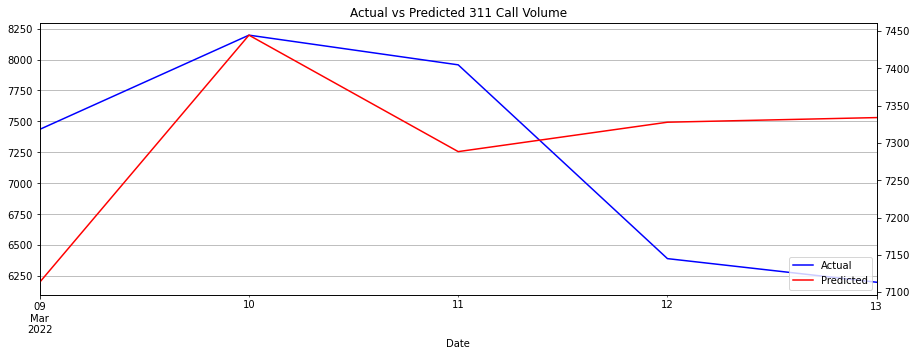

In [62]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')

ax1 = compare ['311 Call Volume'].plot(color='blue', grid=True, label='Actual')
ax2 = compare['311 Call Volume_predicted'].plot(color='red', grid=True, secondary_y=True, label='Predicted')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=4)
plt.title('Actual vs Predicted 311 Call Volume')
plt.show()